# Modeling Stock Price Dynamics as Markov Processes - Part 3

The code imported from `rl` can be found [here](https://github.com/sunnyliketheweather94/machine-learning-and-more/blob/main/projects/reinforcement_learning/foundations/rl).

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

import itertools
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np

from rl.distributions import Categorical, Constant
from rl.markov_process import MarkovProcess, NonTerminal, State
from rl.math import get_unit_sigmoid_function

In [3]:
@dataclass(frozen=True)
class StateMP3:
    num_up_moves: int
    num_down_moves: int


@dataclass
class StockPriceMP3(MarkovProcess[StateMP3]):
    alpha: float = 1.0  # strength of reverse-pull (non-negative value)

    def calculate_up_prob(self, state: StateMP3) -> float:
        total = state.num_up_moves + state.num_down_moves

        if total:
            return get_unit_sigmoid_function(alpha=self.alpha)(
                state.num_down_moves / total
            )

        else:
            return 0.5

    def transition(self, state: NonTerminal[StateMP3]) -> Categorical[State[StateMP3]]:
        up_prob = self.calculate_up_prob(state=state.state)

        return Categorical(
            {
                NonTerminal(
                    StateMP3(
                        num_up_moves=state.state.num_up_moves + 1,
                        num_down_moves=state.state.num_down_moves,
                    )
                ): up_prob,
                NonTerminal(
                    StateMP3(
                        num_up_moves=state.state.num_up_moves,
                        num_down_moves=state.state.num_down_moves + 1,
                    )
                ): 1.0 - up_prob,
            }
        )

In [4]:
def process3_price_traces(
    start_price: int,
    alpha: float,
    time_steps: int,
    num_traces: int,
) -> np.ndarray:
    mp = StockPriceMP3(alpha=alpha)

    start_state_distribution = Constant(
        NonTerminal(StateMP3(num_up_moves=0, num_down_moves=0))
    )

    return np.vstack(
        [
            np.fromiter(
                (
                    start_price + s.state.num_up_moves - s.state.num_down_moves
                    for s in itertools.islice(
                        mp.simulate(start_state_distribution=start_state_distribution),
                        time_steps + 1,
                    )
                ),
                float,
            )
            for _ in range(num_traces)
        ]
    )

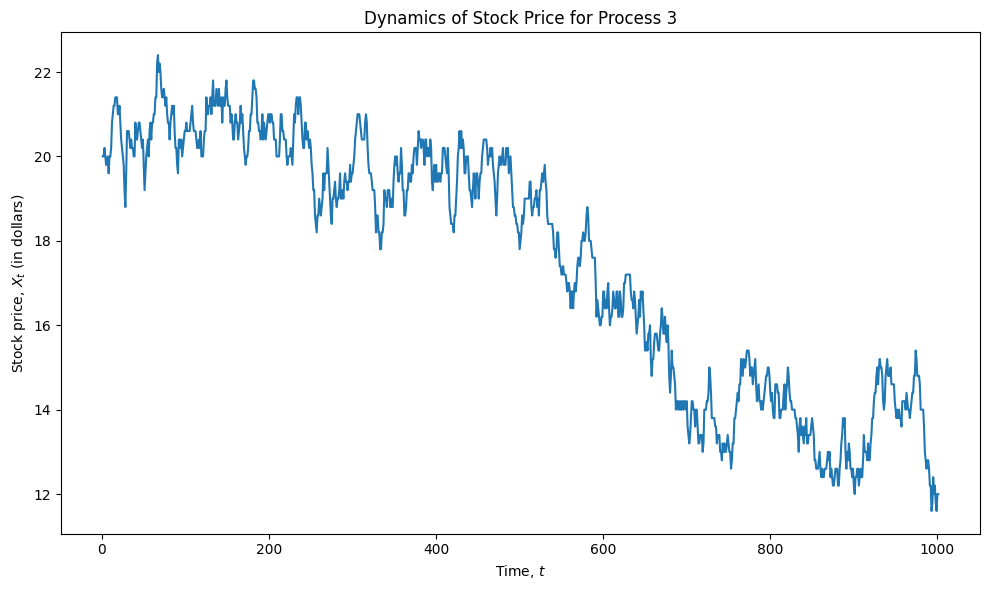

In [13]:
traces = process3_price_traces(
    start_price=20,
    alpha=0.2,
    time_steps=1_000,
    num_traces=10,
)

traces = traces.T
traces = np.mean(traces, axis=1)

plt.subplots(figsize=(10, 6))
plt.plot(range(1, traces.shape[0] + 1), traces)

plt.title("Dynamics of Stock Price for Process 3")
plt.xlabel("Time, $t$")
plt.ylabel("Stock price, $X_t$ (in dollars)")

plt.tight_layout()
plt.show()

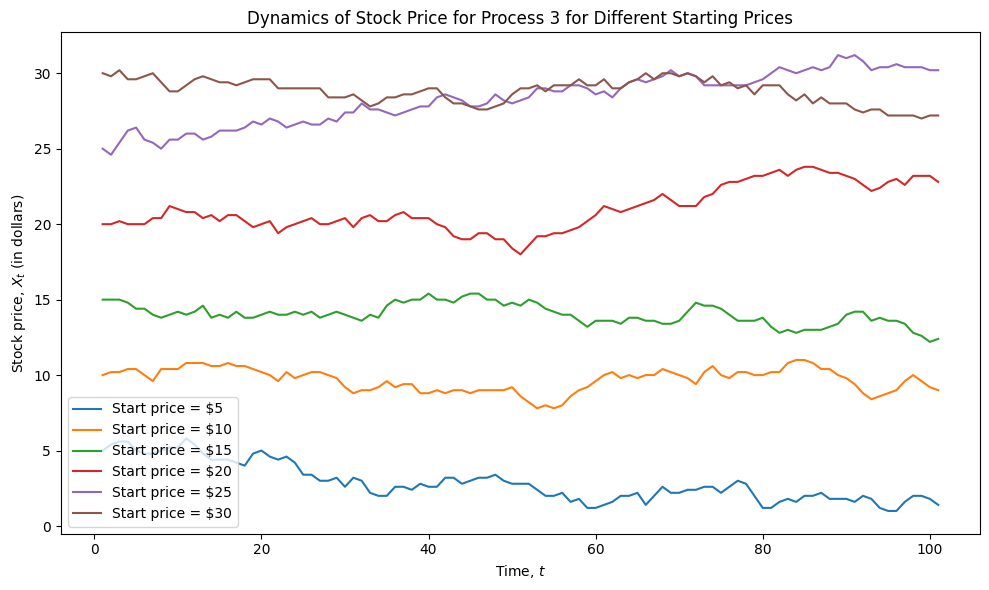

In [12]:
plt.subplots(figsize=(10, 6))


for start_price in [5, 10, 15, 20, 25, 30]:
    traces = process3_price_traces(
        start_price=start_price,
        alpha=0.1,
        time_steps=100,
        num_traces=10,
    )

    traces = traces.T
    traces = np.mean(traces, axis=1)

    plt.plot(
        range(1, traces.shape[0] + 1),
        traces,
        label=f"Start price = ${start_price}",
    )


plt.title("Dynamics of Stock Price for Process 3 for Different Starting Prices")
plt.xlabel("Time, $t$")
plt.ylabel("Stock price, $X_t$ (in dollars)")

plt.legend()
plt.tight_layout()
plt.show()

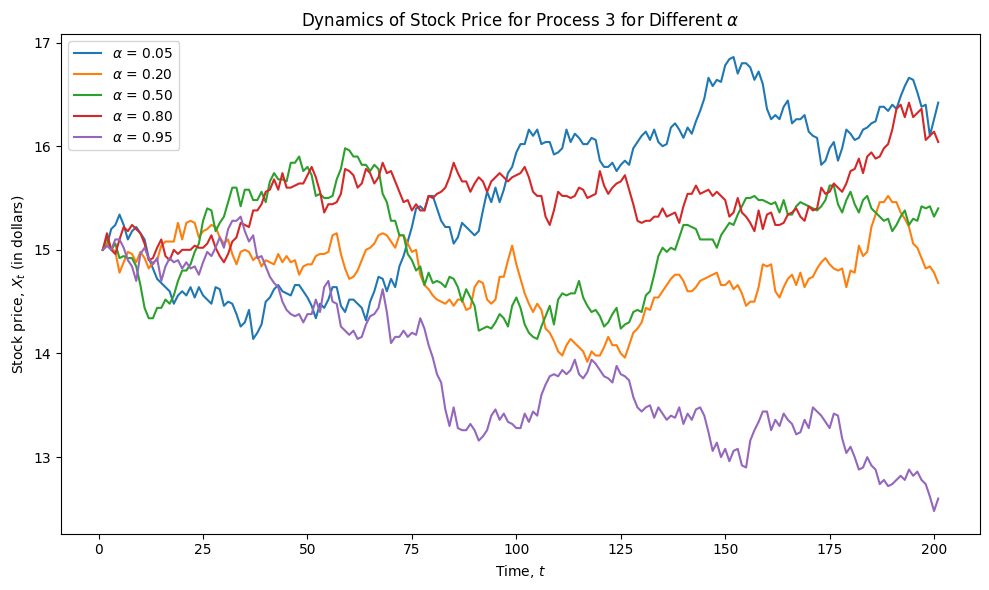

In [9]:
plt.subplots(figsize=(10, 6))


for alpha in [0.05, 0.2, 0.5, 0.8, 0.95]:
    traces = process3_price_traces(
        start_price=15,
        alpha=alpha,
        time_steps=200,
        num_traces=100,
    )

    traces = traces.T
    traces = np.mean(traces, axis=1)

    plt.plot(
        range(1, traces.shape[0] + 1),
        traces,
        label=f"$\\alpha$ = {alpha:.2f}",
    )


plt.title("Dynamics of Stock Price for Process 3 for Different $\\alpha$")
plt.xlabel("Time, $t$")
plt.ylabel("Stock price, $X_t$ (in dollars)")

plt.legend()
plt.tight_layout()
plt.show()

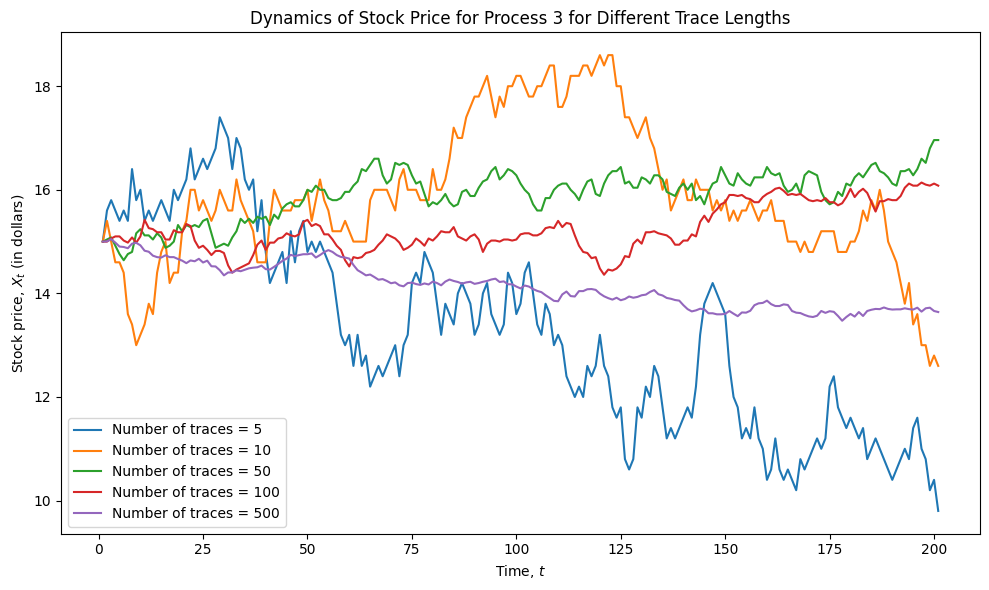

In [11]:
plt.subplots(figsize=(10, 6))


for n_trace in [5, 10, 50, 100, 500]:
    traces = process3_price_traces(
        start_price=15,
        alpha=0.15,
        time_steps=200,
        num_traces=n_trace,
    )

    traces = traces.T
    traces = np.mean(traces, axis=1)

    plt.plot(
        range(1, traces.shape[0] + 1),
        traces,
        label=f"Number of traces = {n_trace}",
    )

plt.title("Dynamics of Stock Price for Process 3 for Different Trace Lengths")
plt.xlabel("Time, $t$")
plt.ylabel("Stock price, $X_t$ (in dollars)")

plt.legend()
plt.tight_layout()
plt.show()